In [1]:
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
import gc

## 1.  Exploratory data analysis

In [2]:
train = pd.read_csv("application_train.csv")
test = pd.read_csv("application_test.csv")

### 1.1 Unbalanced class problem

The loan was repaid in the percentage of  91.93 %
The loan was not repaid in the percentage of  8.07 %


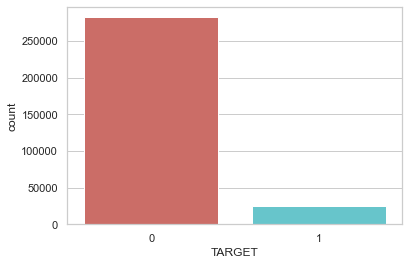

In [3]:
train.TARGET.value_counts()
sns.countplot(x='TARGET', data= train, palette='hls')

count_loan_repaid = len(train[train['TARGET']==0])
count_loan_no_repaid = len(train[train['TARGET']==1])
pct_of_loan_repaid = count_loan_repaid/(count_loan_no_repaid+count_loan_repaid)
print("The loan was repaid in the percentage of ", round(pct_of_loan_repaid*100, 2), '%')
pct_of_loan_no_repaid = count_loan_no_repaid/(count_loan_no_repaid+count_loan_repaid)
print("The loan was not repaid in the percentage of ", round(pct_of_loan_no_repaid*100,2), '%')

The plot above shows the we are delaing with an imbalanced class problem, in particular the ratio of repaid-loans to no-repaid-loan is 92:8.

### 1.2 Merging train and test datasets

In [4]:
# Alignement of the columns of the train and test dataset
target = train[['SK_ID_CURR','TARGET']]
train.drop('TARGET', axis=1)
train, test = train.align(test, join = 'inner', axis = 1)

In [5]:
# Concatenate train and test
trainTest = pd.concat([train, test], ignore_index=True, sort=False)

In [6]:
trainTest.shape

(356255, 121)

In [7]:
del train
del test

### 1.3 Anomalies in the train and test datasets

In [8]:
# Substitute the column DAYS_BIRTH with one stating clearly the age of the person
trainTest['AGE'] = trainTest['DAYS_BIRTH']/ -365
trainTest = trainTest.drop('DAYS_BIRTH', axis=1)

In [9]:
trainTest.dtypes.value_counts()

float64    66
int64      39
object     16
dtype: int64

In [10]:
# Keep a list of all the numerical variables, in order to detect and solve eventual anomalies

features = []
for col in trainTest:
    if trainTest[col].dtypes != 'object' and col != 'SK_ID_CURR':
        features.append(col)

len(features)

104

C:\Users\Clara\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Clara\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


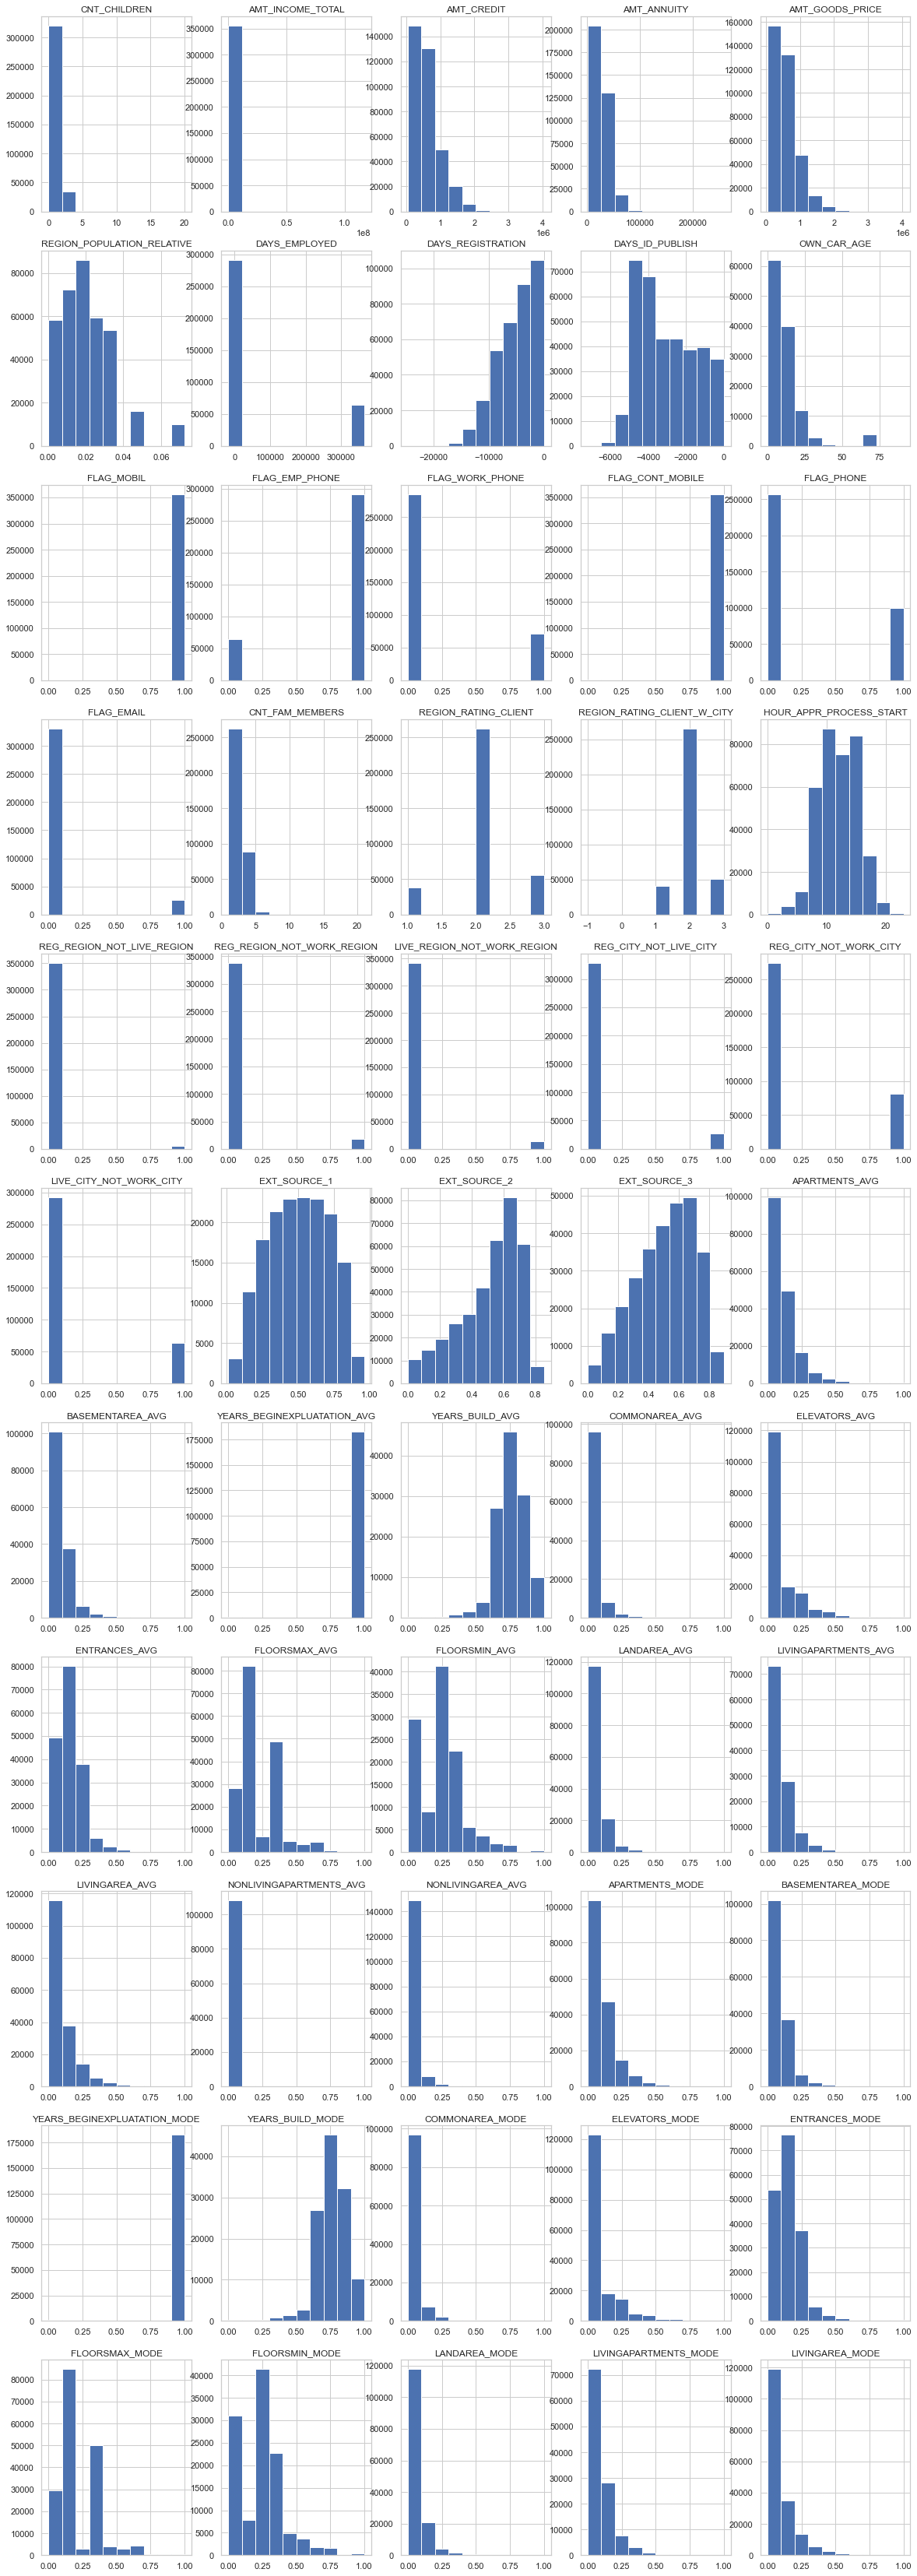

In [11]:
fig, ax = plt.subplots(11, 5, figsize=(20,60))
counter =  0
for i in range(11):
    for j in range(5):
        ax[i, j].hist(trainTest[features[counter]])
        ax[i, j].set_title(features[counter])
        counter +=1

#### 1.3.1 DAYS_EMPLOYED

In [12]:
trainTest['DAYS_EMPLOYED'].describe()

count    356255.000000
mean      64317.231413
std      141705.532576
min      -17912.000000
25%       -2781.000000
50%       -1224.000000
75%        -290.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

In [13]:
trainTest['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
# Replace the anomalies with mean value obtained from above
trainTest['DAYS_EMPLOYED'].replace({365243: -2397}, inplace = True)

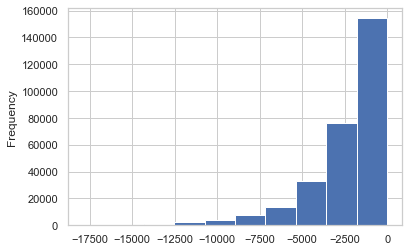

In [14]:
trainTest['DAYS_EMPLOYED'].plot(kind='hist')

#### 1.3.2 OWN_CAR_AGE 

In [15]:
carAgeMode = trainTest['OWN_CAR_AGE'].mode(dropna=False)
trainTest[trainTest['OWN_CAR_AGE']>40]['OWN_CAR_AGE'].unique()

array([65., 64., 41., 42., 54., 43., 55., 49., 44., 63., 46., 45., 48.,
       56., 51., 57., 69., 50., 47., 91., 52., 74.])

In [16]:
trainTest['OWN_CAR_AGE'] = trainTest['OWN_CAR_AGE'].apply(lambda x: np.where(x > 40,carAgeMode[0],x))

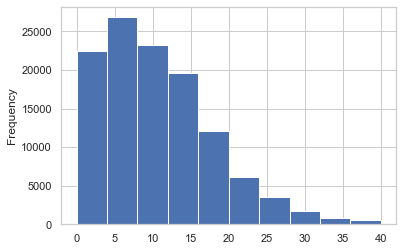

In [17]:
trainTest['OWN_CAR_AGE'].plot(kind='hist')

#### 1.3.3 REGION_RATING_CLIENT_W_CITY 

This feature can take values only in {1,2,3}

In [18]:
trainTest['REGION_RATING_CLIENT_W_CITY'].describe()

count    356255.000000
mean          2.028932
std           0.504586
min          -1.000000
25%           2.000000
50%           2.000000
75%           2.000000
max           3.000000
Name: REGION_RATING_CLIENT_W_CITY, dtype: float64

In [19]:
trainTest['REGION_RATING_CLIENT_W_CITY'].replace({-1: 1}, inplace = True)

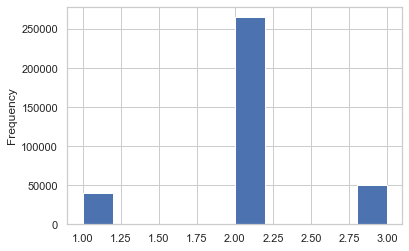

In [20]:
trainTest['REGION_RATING_CLIENT_W_CITY'].plot(kind='hist')

### 1.4 Analysis of other datasets and aggregation with the train dataset
#### 1.4.1 PREV_APPLICATION

In [21]:
prev_application = pd.read_csv("previous_application.csv")

In [22]:
prev_application.dtypes.value_counts()

object     16
float64    15
int64       6
dtype: int64

In [23]:
# Keep a list of all the numerical variables, in order to detect and solve eventual anomalies
features = []
for col in prev_application:
    if prev_application[col].dtypes != 'object' and col != 'SK_ID_CURR':
        features.append(col)
len(features)

20

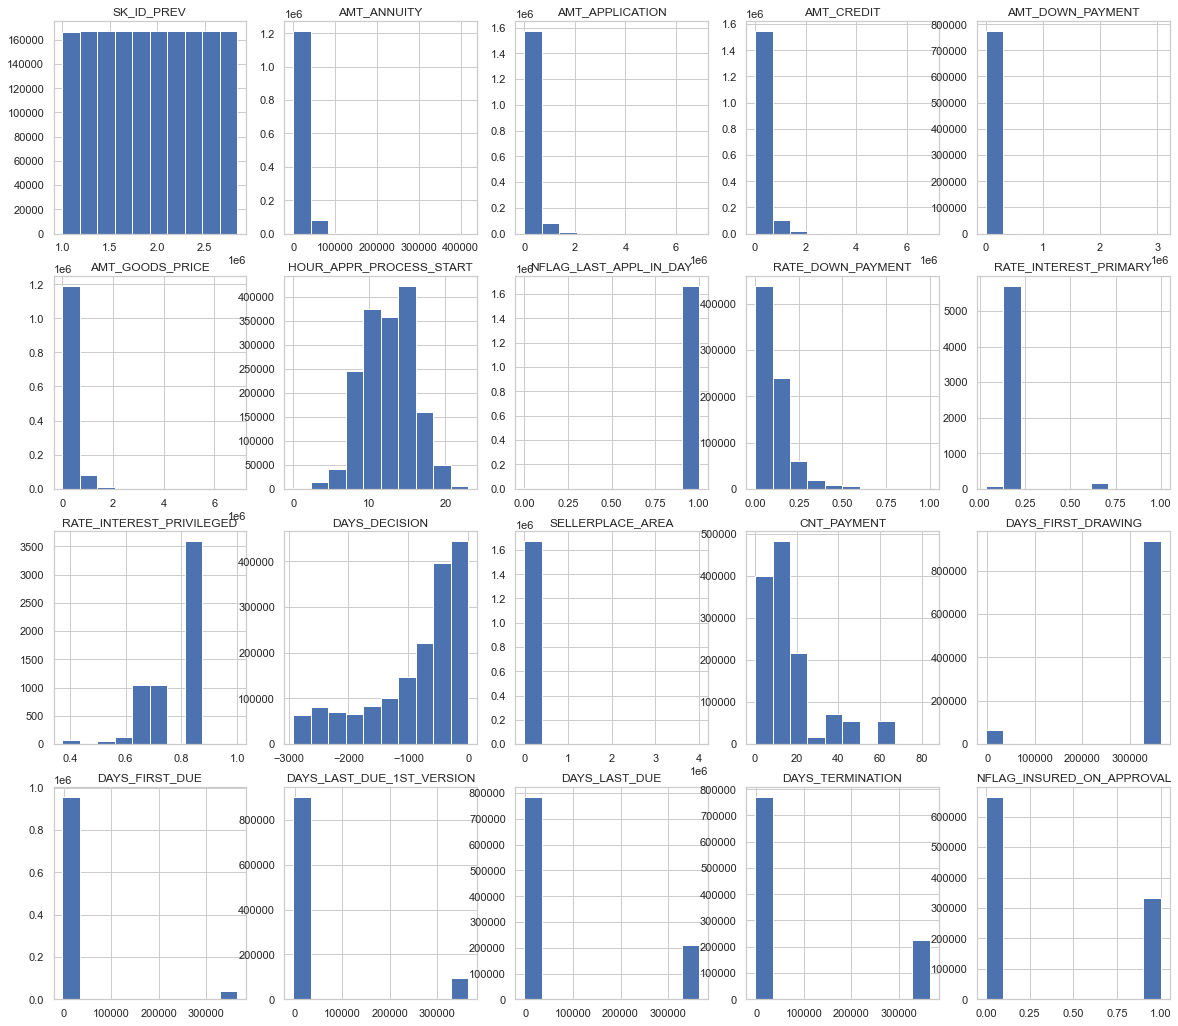

In [24]:
fig, ax = plt.subplots(4, 5, figsize=(20,18))
counter =  0
for i in range(4):
    for j in range(5):
        ax[i, j].hist(prev_application[features[counter]])
        ax[i, j].set_title(features[counter])
        counter +=1

In [25]:
featuresWithAnomalies = ['DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION']

In [26]:
# Replace the anomalies with the mean value of the correct available data
for feat in featuresWithAnomalies:
    prev_application[feat].replace({365243: np.nan}, inplace = True)
    meanValue = prev_application[feat].mean()
    prev_application[feat].replace({365243: meanValue}, inplace = True)

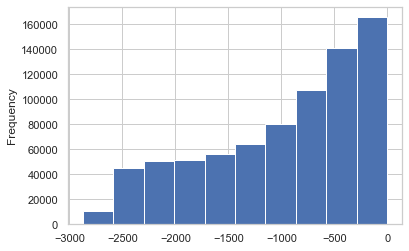

In [27]:
prev_application['DAYS_TERMINATION'].plot(kind='hist')

In [28]:
trainTest = trainTest.merge(prev_application.groupby('SK_ID_CURR').mean(), how='left', on='SK_ID_CURR')

In [29]:
del prev_application

In [30]:
gc.collect()

253

#### 1.4.2 POS_CASH_balance

In [31]:
POS_CASH_balance = pd.read_csv("POS_CASH_balance.csv")

In [32]:
POS_CASH_balance.dtypes.value_counts()

int64      5
float64    2
object     1
dtype: int64

In [33]:
# Keep a list of all the numerical variables, in order to detect and solve eventual anomalies
featuresPOS = []
for col in POS_CASH_balance:
    if POS_CASH_balance[col].dtypes != 'object' and col != 'SK_ID_CURR' and col != 'SK_ID_PREV':
        featuresPOS.append(col)
len(featuresPOS)

5

Text(0.5, 1.0, 'SK_DPD_DEF')

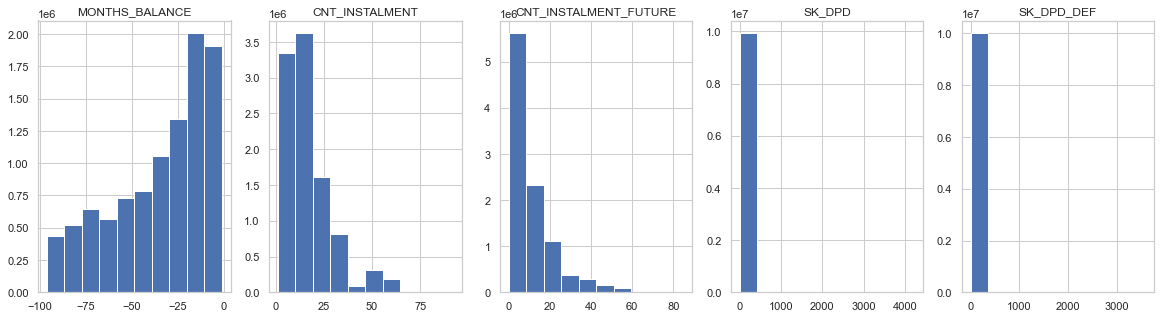

In [34]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize = (20,5))
ax1.hist(POS_CASH_balance[featuresPOS[0]])
ax1.set_title(featuresPOS[0])
ax2.hist(POS_CASH_balance[featuresPOS[1]])
ax2.set_title(featuresPOS[1])
ax3.hist(POS_CASH_balance[featuresPOS[2]])
ax3.set_title(featuresPOS[2])
ax4.hist(POS_CASH_balance[featuresPOS[3]])
ax4.set_title(featuresPOS[3])
ax5.hist(POS_CASH_balance[featuresPOS[4]])
ax5.set_title(featuresPOS[4])

In [35]:
print('Percentage of loans having SK_DPD = 0:', len(POS_CASH_balance[POS_CASH_balance['SK_DPD']==0])/len(POS_CASH_balance)*100, '%')

Percentage of loans having SK_DPD = 0: 97.0481308638287 %


In [36]:
print('Percentage of loans having SK_DPD_DEF = 0:', len(POS_CASH_balance[POS_CASH_balance['SK_DPD_DEF']==0])/len(POS_CASH_balance)*100, '%')

Percentage of loans having SK_DPD_DEF = 0: 98.8604647488871 %


Since the feature ***SK_DPD*** and ***SK_DPD_DEF*** doesn't seem to be very significance, we decide to remove them

In [37]:
POS_CASH_balance.drop(['SK_DPD', 'SK_DPD_DEF'], axis=1, inplace=True)

In [38]:
gc.collect()

102

In [39]:
POS_CASH_balance.drop(['SK_ID_CURR'], axis=1, inplace=True)
trainTest = trainTest.merge(POS_CASH_balance.groupby('SK_ID_PREV').mean(), how='left', on='SK_ID_PREV')

C:\Users\Clara\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:938: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  'representation', UserWarning)


In [40]:
del POS_CASH_balance
gc.collect()

75

#### 1.4.3 INSTALLMENT_PAYMENTS

In [41]:
installments_payments = pd.read_csv("installments_payments.csv")

In [42]:
installments_payments.dtypes.value_counts()

float64    5
int64      3
dtype: int64

In [43]:
# Keep a list of all the numerical variables, in order to detect and solve eventual anomalies
featuresINST = []
for col in installments_payments:
    if col != 'SK_ID_CURR' and col != 'SK_ID_PREV':
        featuresINST.append(col)
len(featuresINST)

6

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000015010A01908>,
      dtype=object)

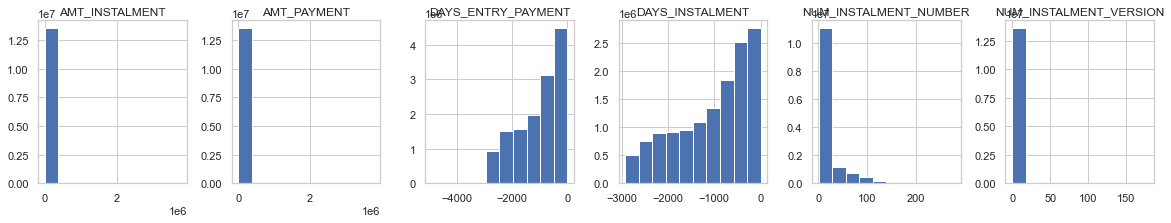

In [44]:
installments_payments[featuresINST].hist(layout=(1,6), figsize=(20,3))

In [45]:
installments_payments.drop(['AMT_INSTALMENT', 'AMT_PAYMENT', 'NUM_INSTALMENT_VERSION'], axis=1, inplace=True)

In [46]:
installments_payments.drop(['SK_ID_CURR'], axis=1, inplace=True)
trainTest = trainTest.merge(installments_payments.groupby('SK_ID_PREV').mean(), how='left', on='SK_ID_PREV')

In [47]:
del installments_payments
gc.collect()

147

#### 1.4.4 CREDIT_CARD_BALANCE

In [48]:
credit_card_balance = pd.read_csv("credit_card_balance.csv")

In [49]:
credit_card_balance.dtypes.value_counts()

float64    15
int64       7
object      1
dtype: int64

In [50]:
# Keep a list of all the numerical variables, in order to detect and solve eventual anomalies
featuresCC = []
for col in credit_card_balance:
    if credit_card_balance[col].dtypes != 'object' and col != 'SK_ID_CURR' and col != 'SK_ID_PREV':
        featuresCC.append(col)
len(featuresCC)

20

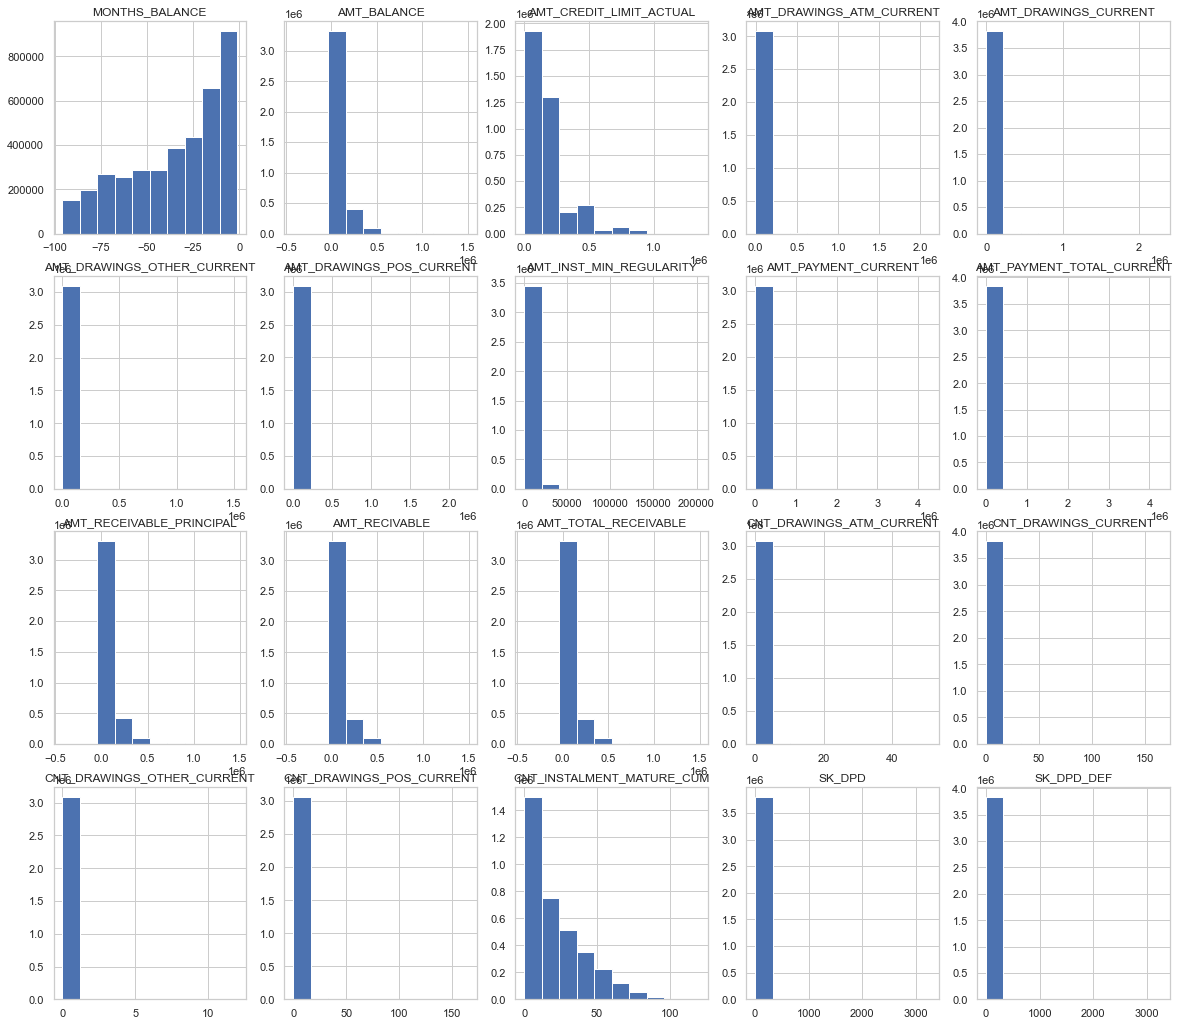

In [51]:
fig, ax = plt.subplots(4, 5, figsize=(20,18))
counter =  0
for i in range(4):
    for j in range(5):
        ax[i, j].hist(credit_card_balance[featuresCC[counter]])
        ax[i, j].set_title(featuresCC[counter])
        counter +=1

In [52]:
credit_card_balance['AMT_DRAWINGS_ATM_CURRENT'].describe()

count    3.090496e+06
mean     5.961325e+03
std      2.822569e+04
min     -6.827310e+03
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.115000e+06
Name: AMT_DRAWINGS_ATM_CURRENT, dtype: float64

In [53]:
credit_card_balance.drop(['SK_ID_CURR'], axis=1, inplace=True)
trainTest = trainTest.merge(credit_card_balance.groupby('SK_ID_PREV').mean(), how='left', on='SK_ID_PREV')

In [54]:
del credit_card_balance
gc.collect()

137

#### 1.4.5 BUREAU

In [55]:
bureau = pd.read_csv("bureau.csv")

In [56]:
bureau.dtypes.value_counts()

float64    8
int64      6
object     3
dtype: int64

In [57]:
featuresB = []
for col in bureau:
    if bureau[col].dtypes != 'object' and col != 'SK_ID_CURR' and col != 'SK_ID_BUREAU':
        featuresB.append(col)
len(featuresB)

12

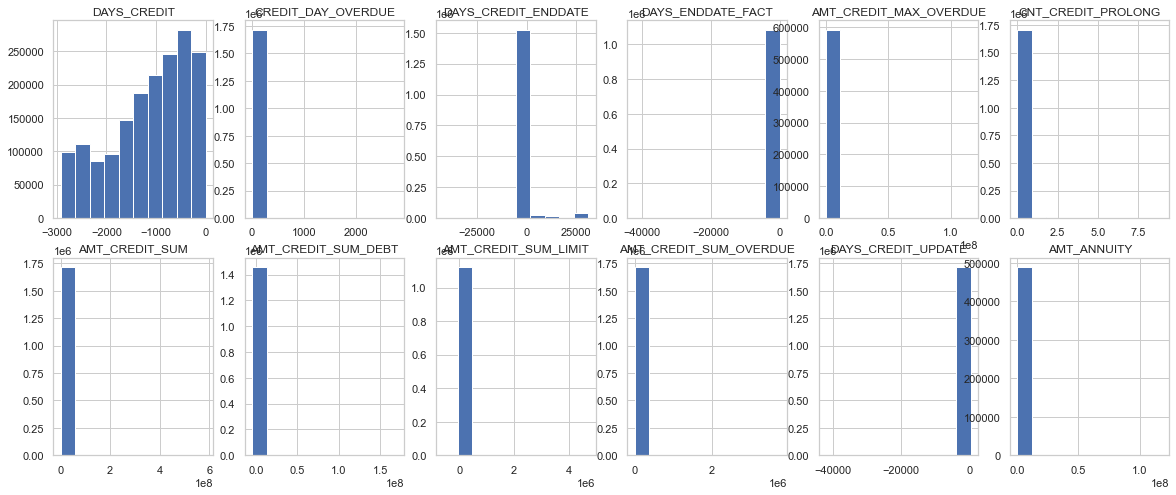

In [58]:
fig, ax = plt.subplots(2, 6, figsize=(20,8))
counter =  0
for i in range(2):
    for j in range(6):
        ax[i, j].hist(bureau[featuresB[counter]])
        ax[i, j].set_title(featuresB[counter])
        counter +=1

#### 1.4.6 BUREAU_BALANCE

In [59]:
bureau_balance = pd.read_csv("bureau_balance.csv")

In [60]:
bureau_balance.dtypes.value_counts()

int64     2
object    1
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001500EDE90F0>,
      dtype=object)

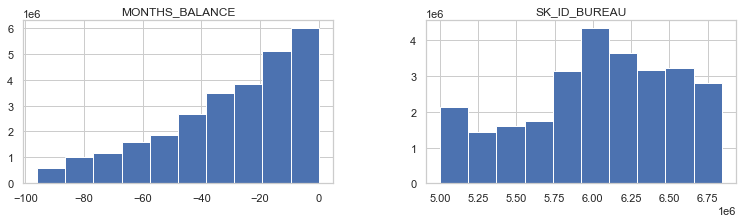

In [61]:
bureau_balance.hist(layout=(1,3), figsize=(20,3))

In [62]:
#for status in bureau_balance['STATUS'].unique():
#    bureau_balance['STATUS_' + status] = (bureau_balance['STATUS'] == status).map(int)
#bureau_balance.drop('STATUS', axis = 1, inplace = True)

Merge the dataset *bureau_balace* with *bureau* on the column ***SK_ID_BUREAU***

In [63]:
bureau = bureau.merge(right = bureau_balance.groupby('SK_ID_BUREAU').mean(), how='left', on='SK_ID_BUREAU')

In [64]:
del bureau_balance
gc.collect()

55055

In [65]:
trainTest = trainTest.merge(right = bureau.groupby('SK_ID_CURR').mean(), how='left', on='SK_ID_CURR')

In [66]:
del bureau
gc.collect()

68

### 1.5 Encoding categorical variables and removing missing values

In [67]:
trainTest.shape

(356255, 181)

#### 1.5.1 Categorical variables

In [68]:
trainTest.dtypes.value_counts()

float64    127
int64       38
object      16
dtype: int64

In [69]:
trainTest.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

Encoding of categorical variables having only two alternatives, i.e. corresponding to 0-1

In [70]:
binaryObjectFeatures = ['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'EMERGENCYSTATE_MODE']

In [71]:
for col in binaryObjectFeatures:
    print(trainTest[col].unique())

['Cash loans' 'Revolving loans']
['N' 'Y']
['Y' 'N']
['No' nan 'Yes']


In [72]:
print('Percentage of missing values for the feature EMERGENCYSTATE_MODE: ', trainTest['EMERGENCYSTATE_MODE'].isnull().sum()/trainTest.shape[0]*100, '%')

Percentage of missing values for the feature EMERGENCYSTATE_MODE:  47.14712775961039 %


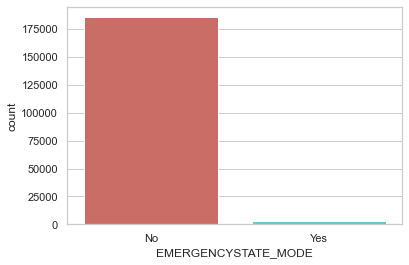

In [73]:
trainTest.EMERGENCYSTATE_MODE.value_counts()
sns.countplot(x='EMERGENCYSTATE_MODE', data= trainTest, palette='hls')

In [74]:
trainTest['EMERGENCYSTATE_MODE'] = trainTest['EMERGENCYSTATE_MODE'].replace({np.nan:'No'})

In [75]:
gc.collect()

40

In [76]:
le = LabelEncoder()
for col in binaryObjectFeatures:
    trainTest[col] = le.fit_transform(trainTest[col])
trainTest.dtypes.value_counts()

float64    127
int64       38
object      12
int32        4
dtype: int64

One-hot encoding of categorical variables having more than two alternatives

In [77]:
trainTest = pd.get_dummies(trainTest)
trainTest.dtypes.value_counts()

uint8      132
float64    127
int64       38
int32        4
dtype: int64

In [78]:
gc.collect()
trainTest.shape

(356255, 301)

#### 1.5.2 Missing values

In [79]:
def summary_missing_values(df):
    mising_values_sum = df.isnull().sum()
    mising_values_percentage = 100 * df.isnull().sum() / len(df)
    summary = pd.concat([mising_values_sum, mising_values_percentage], axis=1)
    summary.columns = ['Number of missing values','Percentage of missing values']    
    return summary.sort_values(by=['Percentage of missing values'], ascending=False)    

In [80]:
nanDf = summary_missing_values(trainTest)

In [81]:
colWithNan = list(nanDf[nanDf['Percentage of missing values'] > 0].index)
len(colWithNan)

122

In [82]:
colToDrop = list(nanDf[nanDf['Percentage of missing values'] > 79].index)

In [83]:
colWithNan = [col for col in colWithNan if col not in colToDrop]

In order to reduce the dimensionality of the problem, I decide to drop all the columns having a high number of missing values, namely those having a percentage og missing values higher than 79%:

In [84]:
trainTest.drop(colToDrop, axis=1, inplace=True)
trainTest.shape

(356255, 278)

In [85]:
del nanDf
gc.collect()

154

In [86]:
for col in colWithNan:
    trainTest[col] = trainTest[col].fillna(trainTest[col].median())

In [87]:
trainTest.isnull().values.any()

False

#### 1.5.3 Normalizing features

In [88]:
ss = StandardScaler()
ids = trainTest['SK_ID_CURR']
trainTest.drop('SK_ID_CURR', axis = 1, inplace = True)
df = ss.fit_transform(trainTest)
trainTest = pd.DataFrame(df, columns = trainTest.columns)
trainTest['SK_ID_CURR'] = ids

In [89]:
del df
del ids
gc.collect()

101

## Automated feature engineering

In [103]:
import featuretools as ft

In [104]:
trainTest.shape

(356255, 278)

In [105]:
es = ft.EntitySet(id = 'HomeCreditRiskSet')

In [106]:
es = es.entity_from_dataframe(entity_id = 'applicantData', dataframe = trainTest, index = 'SK_ID_CURR')

In [107]:
es

Entityset: HomeCreditRiskSet
  Entities:
    applicantData [Rows: 356255, Columns: 278]
  Relationships:
    No relationships

In [108]:
agg_prim =  ["sum", "std", "max", "skew", "min", "mean", "count", "percent_true", "num_unique", "mode"]
trans_prim =  ["day", "year", "month", "weekday", "haversine"]
features, featuresName = ft.dfs(entityset = es, target_entity = 'applicantData', agg_primitives = agg_prim, trans_primitives = trans_prim) 

In [116]:
feature_defs = ft.dfs(entityset=es,
                      target_entity="applicantData",
                      agg_primitives=["count", "sum"],
                      verbose = True, 
                      max_depth=2, # add max_depth
                      features_only = True)

Built 277 features


In [114]:
gc.collect()

98

## 2. Dimensionality reduction : PCA

In [365]:
from sklearn.decomposition import PCA
# pca - keep 90% of variance
pca = PCA(0.90)
principal_df = pd.DataFrame(pca.fit_transform(trainTest))
principal_df.shape

(356255, 1)

In [367]:
del principal_df
gc.collect()

60

## Feature selection

In [ ]:
# find correlations to target
corr_matrix = trainTest.corr().abs()
#corr_matrix['TARGET'].sort_values(ascending=False).head(10)

In [ ]:
del to_drop
gc.collect()

In [377]:
corr_matrix.head()

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,...,HOUSETYPE_MODE_specifichousing,HOUSETYPE_MODE_terracedhouse,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,WALLSMATERIAL_MODE_Stonebrick,WALLSMATERIAL_MODE_Wooden,SK_ID_CURR
NAME_CONTRACT_TYPE,1.000000,0.004196,0.063097,0.028738,0.004814,0.200187,0.228258,0.166441,0.023638,0.025409,...,0.000449,0.000503,0.006311,0.003430,0.010088,0.001496,0.009187,0.013676,0.000661,0.001594
FLAG_OWN_CAR,0.004196,1.000000,0.002093,0.103036,0.089027,0.116992,0.143512,0.121334,0.039089,0.000043,...,0.010243,0.004052,0.005016,0.000612,0.010883,0.003531,0.009905,0.025383,0.010379,0.001552
FLAG_OWN_REALTY,0.063097,0.002093,1.000000,0.001880,0.004258,0.034738,0.001614,0.042361,0.018161,0.014941,...,0.004842,0.007800,0.001517,0.003373,0.001633,0.000718,0.017386,0.018856,0.016049,0.000342
CNT_CHILDREN,0.028738,0.103036,0.001880,1.000000,0.014067,0.005988,0.025991,0.002218,0.024205,0.026577,...,0.001923,0.001961,0.005194,0.001475,0.001703,0.000690,0.018909,0.024217,0.009792,0.000879
AMT_INCOME_TOTAL,0.004814,0.089027,0.004258,0.014067,1.000000,0.166590,0.204387,0.169462,0.081087,0.023685,...,0.002423,0.000568,0.012830,0.005985,0.025391,0.003965,0.034717,0.016735,0.003601,0.001605


In [384]:
features = corr_matrix.columns
to_drop  = []
for col in features: 
    for row in features:
        if row != col and corr_matrix.loc[row, col] > 0.9:
            to_drop.append((row, col))

In [385]:
len(to_drop)

118

## Logistic regression model : LightGBM Classifier - 0.76353

Divide train and test dataset

In [94]:
trainIds = target['SK_ID_CURR']

In [95]:
trainTest = trainTest.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [106]:
train = trainTest[trainTest['SK_ID_CURR'].isin(trainIds)]
test = trainTest[~trainTest['SK_ID_CURR'].isin(trainIds)]
y = target['TARGET']
gc.collect()

27

In [ ]:
from sklearn.model_selection import KFold 
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score

excluded_feats = ['SK_ID_CURR']
features = [f_ for f_ in train.columns if f_ not in excluded_feats]

# Modeling
folds = KFold(n_splits=5, shuffle=True, random_state=123)
oof_preds = np.zeros(train.shape[0])
sub_preds = np.zeros(test.shape[0])
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train)):
    trn_x, trn_y = train[features].iloc[trn_idx], y.iloc[trn_idx]
    val_x, val_y = train[features].iloc[val_idx], y.iloc[val_idx]
    
    clf = LGBMClassifier(
        n_estimators=2000,
        learning_rate=0.1,
        num_leaves=123,
        colsample_bytree=.8,
        subsample=.9,
        max_depth=15,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01,
        min_child_weight=2
    )
    
    clf.fit(trn_x, trn_y, 
            eval_set= [(trn_x, trn_y), (val_x, val_y)], 
            eval_metric='auc', verbose=250, early_stopping_rounds=150
           )
    
    oof_preds[val_idx] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
    sub_preds += clf.predict_proba(test[features], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
    
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx])))
    del clf, trn_x, trn_y, val_x, val_y
    gc.collect()

### LightGBM model 2 - 0.76504

In [92]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.feature_selection import VarianceThreshold
import lightgbm as lgb

In [97]:
test.shape

(48744, 278)

Use the parameter *scale_pos_weight = (number of negative samples) / (number of positive samples)* to balance the data:

In [98]:
sample_pos_weight = count_loan_repaid / count_loan_no_repaid
sample_pos_weight

11.387150050352467

In [107]:
train_x, test_x, train_y, test_y = train_test_split(train, y, test_size=0.2, shuffle=True)

train_data=lgb.Dataset(train_x,label=train_y)
test_data=lgb.Dataset(test_x,label=test_y)

params = {'boosting_type': 'gbdt',
          'max_depth' : 10,
          'objective': 'binary',
          'nthread': 5,
          'num_leaves': 64,
          'learning_rate': 0.05,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 5,
          'reg_lambda': 10,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'auc'
          }

#Train model on selected parameters and number of iterations
lgbm = lgb.train(params,
                 train_data,
                 2500,
                 valid_sets=test_data,
                 early_stopping_rounds= 40,
                 verbose_eval= 10
                 )

#Predict on test set and write to submit
predictions_lgbm_prob = lgbm.predict(test)

test['TARGET'] = predictions_lgbm_prob

test[['SK_ID_CURR', 'TARGET']].to_csv('submissionLGBmodel.csv', index=False)

Training until validation scores don't improve for 40 rounds
[10]	valid_0's auc: 0.730408
[20]	valid_0's auc: 0.739493
[30]	valid_0's auc: 0.743406
[40]	valid_0's auc: 0.746806
[50]	valid_0's auc: 0.750334
[60]	valid_0's auc: 0.753573
[70]	valid_0's auc: 0.755757
[80]	valid_0's auc: 0.757423
[90]	valid_0's auc: 0.758711
[100]	valid_0's auc: 0.759829
[110]	valid_0's auc: 0.760732
[120]	valid_0's auc: 0.761436
[130]	valid_0's auc: 0.762082
[140]	valid_0's auc: 0.762493
[150]	valid_0's auc: 0.762919
[160]	valid_0's auc: 0.76318
[170]	valid_0's auc: 0.763699
[180]	valid_0's auc: 0.764008
[190]	valid_0's auc: 0.764102
[200]	valid_0's auc: 0.764316
[210]	valid_0's auc: 0.764487
[220]	valid_0's auc: 0.764701
[230]	valid_0's auc: 0.764964
[240]	valid_0's auc: 0.764986
[250]	valid_0's auc: 0.765153
[260]	valid_0's auc: 0.765361
[270]	valid_0's auc: 0.76543
[280]	valid_0's auc: 0.765322
[290]	valid_0's auc: 0.765414
[300]	valid_0's auc: 0.765518
[310]	valid_0's auc: 0.765425
[320]	valid_0's auc:

C:\Users\Clara\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


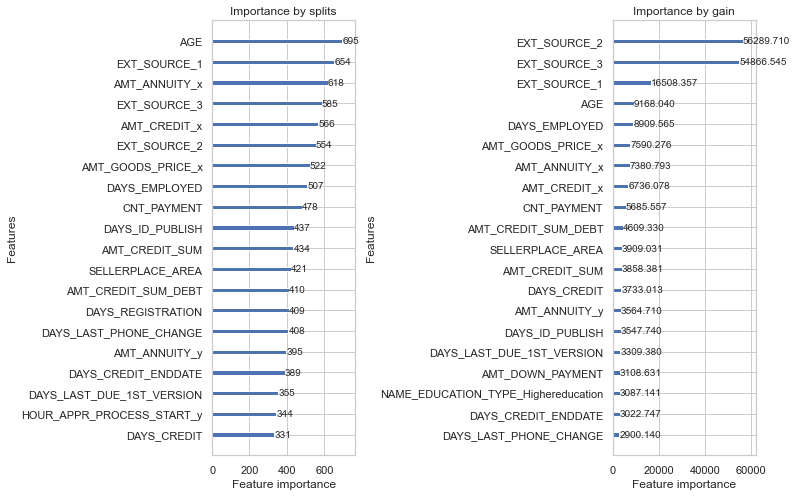

In [110]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=[11, 7])
lgb.plot_importance(lgbm, ax=ax, max_num_features=20, importance_type='split')
lgb.plot_importance(lgbm, ax=ax1, max_num_features=20, importance_type='gain')
ax.set_title('Importance by splits')
ax1.set_title('Importance by gain')
plt.tight_layout()

In [113]:
lgb.feature_importances_

AttributeError: module 'lightgbm' has no attribute 'feature_importances_'

## Submission

In [ ]:
print('Full AUC score %.6f' % roc_auc_score(y, oof_preds))   

test['TARGET'] = sub_preds

test[['SK_ID_CURR', 'TARGET']].to_csv('submissionLGBmodel.csv', index=False, float_format='%.8f')